# ***Anomaly Detection using KNN***

# **Section 1 - Establishing a Connection Between Google Drive and Google Colab**
*To streamline our workflow and seamlessly access project-related files, we'll establish a connection with Google Drive. This integration ensures a smooth collaboration between Google Drive and Google Colab, enabling efficient handling of relevant files throughout the project.*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Section 2 - Useful Imports**
*This next code section includes the import of libraries and functions that will be useful during the process of performing the anomaly detection in the audio files*

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for enhanced visualizations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

# **Section 3 - Loading Embeddings**
*This code section loads pre-generated audio embeddings for training, validation, and testing.*


In [3]:
try:
    train_embeddings = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/train_embeddings.npy')
    val_embeddings = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/val_embeddings.npy')
    test_embeddings = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/test_embeddings.npy')
except FileNotFoundError:
    raise FileNotFoundError("Embeddings file not found. Please check the file paths.")

# **Section 4 - Splitting Embeddings**
*This code section splits the loaded embeddings into anomaly and normal embeddings.*


In [4]:
try:
    anomaly_embeddings_train = train_embeddings[:224]  # First 224 elements are anomalies
    normal_embeddings_train = train_embeddings[224:]   # Remaining elements are normal
except IndexError:
    raise IndexError("Insufficient data for splitting. Please check the size of embeddings.")

# **Section 5 - Training KNN Model**
*This section defines a function to train a KNN model on normal class embeddings*.


In [5]:
def train_knn_model(normal_embeddings):
    """
    Trains a KNN classifier on the provided normal embeddings.

    Args:
        normal_embeddings (numpy.ndarray): Normal class embeddings for training.

    Returns:
        sklearn.neighbors.KNeighborsClassifier: Trained KNN model.
    """
    knn_model = KNeighborsClassifier(n_neighbors=11)  # Example: Use 11 neighbors

    dimensions = train_embeddings.shape
    print("Dimensions of the array: ", dimensions)

    knn_model.fit(normal_embeddings, np.zeros(len(normal_embeddings)))  # Labeling normal embeddings as 0
    return knn_model

knn_model = train_knn_model(normal_embeddings_train)


Dimensions of the array:  (1481, 49152)


# **Section 6 - Calculating Mean Distances**
*This section defines a function to calculate mean distances for anomaly and normal embeddings.*


In [6]:
def calculate_mean_distances(knn_model, embeddings):
    """
    Calculates mean distances of embeddings using the trained KNN model.

    Args:
        knn_model (sklearn.neighbors.KNeighborsClassifier): Trained KNN model.
        embeddings (numpy.ndarray): Embeddings to calculate distances for.

    Returns:
        numpy.ndarray: Mean distances of embeddings.
    """
    distances, _ = knn_model.kneighbors(embeddings)
    mean_distances = distances.mean(axis=1)
    return mean_distances

In [7]:
anomaly_mean_distance = calculate_mean_distances(knn_model, anomaly_embeddings_train)
normal_mean_distance = calculate_mean_distances(knn_model, normal_embeddings_train)

# Determine threshold based on means and factors
anomaly_threshold = anomaly_mean_distance.mean() + 2 * anomaly_mean_distance.std()  # Example: 2 standard deviations from mean
normal_threshold = normal_mean_distance.mean() - 2 * normal_mean_distance.std()  # Example: 2 standard deviations from mean

print("Anomaly mean:", anomaly_threshold)
print("Normal mean:", normal_threshold)

Anomaly mean: 170.38546810666378
Normal mean: 80.19759271804931


# **Section 7 - Threshold and Label Modification**
*This section calculates thresholds and modifies true labels.*

In [8]:
try:
    true_val_label = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/val_labels.npy')
    true_val_label[: 17] = 1
    true_val_label[17:] = 0

    true_test_label = np.load('/content/drive/MyDrive/AD-Blocker Project/embeddings/test_labels.npy')
    true_test_label[: 17] = 1
    true_test_label[17:] = 0
except FileNotFoundError:
    raise FileNotFoundError("Label file not found. Please check the file paths.")

# **Section 8 - Validation**
*This code section defines a function to validate the KNN model using validation embeddings.*


In [9]:
def validate_knn_model(knn_model, val_embeddings, anomaly_threshold, normal_threshold):
    """
    Validates the KNN model using validation embeddings.

    Args:
        knn_model (sklearn.neighbors.KNeighborsClassifier): Trained KNN model.
        val_embeddings (numpy.ndarray): Validation embeddings.
        anomaly_threshold (float): Threshold for anomalies.
        normal_threshold (float): Threshold for normal samples.

    Returns:
        float: Validation accuracy.
    """
    distances, _ = knn_model.kneighbors(val_embeddings)
    mean_distances = distances.mean(axis=1)
    threshold = (anomaly_threshold + normal_threshold) / 2
    print("threshold: ", threshold)

    val_predictions = mean_distances > threshold  # Threshold based on means

    print (val_predictions.shape)

    print("val_predictions")
    print(val_predictions.astype(int))

    print("true_val_label")
    print(true_val_label)

    val_accuracy = accuracy_score(true_val_label, val_predictions)
    return val_accuracy


In [10]:
val_accuracy = validate_knn_model(knn_model, val_embeddings, anomaly_threshold, normal_threshold)
print("Validation Accuracy:", val_accuracy)

threshold:  125.29153041235654
(160,)
val_predictions
[0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
true_val_label
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Validation Accuracy: 0.95


# **Section 9 - Testing**
*This code section defines a function to test the KNN model using test embeddings.*


In [11]:
def test_knn_model(knn_model, test_embeddings, anomaly_threshold, normal_threshold):
    """
    Tests the KNN model using test embeddings.

    Args:
        knn_model (sklearn.neighbors.KNeighborsClassifier): Trained KNN model.
        test_embeddings (numpy.ndarray): Test embeddings.
        anomaly_threshold (float): Threshold for anomalies.
        normal_threshold (float): Threshold for normal samples.

    Returns:
        float: Test accuracy.
    """
    distances, _ = knn_model.kneighbors(test_embeddings)
    mean_distances = distances.mean(axis=1)
    test_predictions = mean_distances > ((anomaly_threshold + normal_threshold) / 2)

    test_accuracy = accuracy_score(true_test_label, test_predictions)
    return test_accuracy

In [12]:
test_accuracy = test_knn_model(knn_model, test_embeddings, anomaly_threshold, normal_threshold)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.7473118279569892


# **Section 10 - Prediction**
*This section defines a function to predict using the trained KNN model on test embeddings.*


In [13]:
def predict_knn(knn_model, test_embeddings, anomaly_threshold, normal_threshold):
    """
    Predicts using the trained KNN model on test embeddings.

    Args:
        knn_model (sklearn.neighbors.KNeighborsClassifier): Trained KNN model.
        test_embeddings (numpy.ndarray): Test embeddings.
        anomaly_threshold (float): Threshold for anomalies.
        normal_threshold (float): Threshold for normal samples.

    Returns:
        numpy.ndarray: Predictions.
    """
    distances, _ = knn_model.kneighbors(test_embeddings)
    mean_distances = distances.mean(axis=1)
    print("dimensions of test distance", mean_distances.shape )
    test_predictions = mean_distances > ((anomaly_threshold + normal_threshold) / 2)
    test_predictions = mean_distances > ((anomaly_threshold + normal_threshold) / 2)
    return test_predictions.astype(int)

# **Section 11 - Evaluation**
*This section evaluates the performance of the KNN model on test data.*

dimensions of test distance (186,)
predictions
(186,)
[1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 1
 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0]
true_test_label
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
(186,)
Accuracy: 0.7473118279569892
Precision: 0.25806451612903225
Recall (Sensitivity): 0.9411764705882353
F1 Score: 0.4050632911392405
Specificity: 0.727810650887574
ROC 

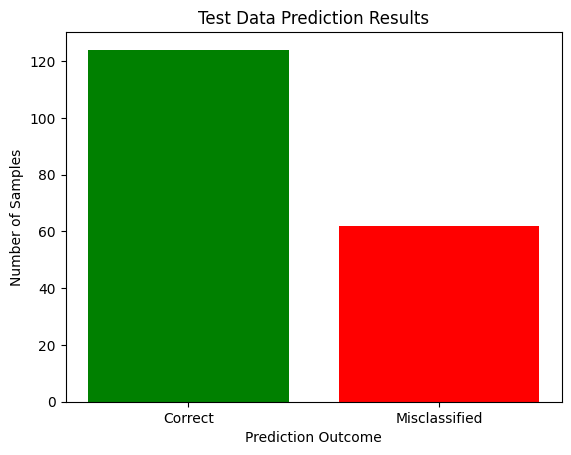

Success Percentage: 66.66666666666666 %


In [ ]:
predictions = predict_knn(knn_model, test_embeddings, anomaly_threshold, normal_threshold)

# Evaluation Metrics
# 1. Accuracy
print("predictions")
print(predictions.shape)
print(predictions)
print("true_test_label")
print(true_test_label)
print(true_test_label.shape)

accuracy = accuracy_score(true_test_label, predictions)
print("Accuracy:", accuracy)

# 2. Precision
precision = precision_score(true_test_label, predictions)
print("Precision:", precision)

# 3. Recall (Sensitivity)
recall = recall_score(true_test_label, predictions)
print("Recall (Sensitivity):", recall)

# 4. F1 Score
f1 = f1_score(true_test_label, predictions)
print("F1 Score:", f1)

# 5. Specificity (Inverse of False Positive Rate)
specificity = recall_score(true_test_label, predictions, pos_label=0)
print("Specificity:", specificity)

# 6. ROC AUC Score
 #roc_auc = roc_auc_score(true_test_label, predictions)
 #print("ROC AUC Score:", roc_auc)

# 7. average_precision_score
pc_auc = average_precision_score(true_test_label, predictions)
print("ROC AUC Score:", pc_auc)

# 8. Confusion Matrix
conf_matrix = confusion_matrix(true_test_label, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calculate number of correctly classified and misclassified samples
correct_count = np.sum(predictions == 0)  # Count of correct predictions
misclassified_count = np.sum(predictions != 0)  # Count of misclassified predictions

# Calculate success percentage
success_percentage = (correct_count / len(predictions)) * 100

# Plotting
labels = ['Correct', 'Misclassified']
counts = [correct_count, misclassified_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.title('Test Data Prediction Results')
plt.show()

print("Success Percentage:", success_percentage, "%")

False Positives: 46
False Negatives: 1


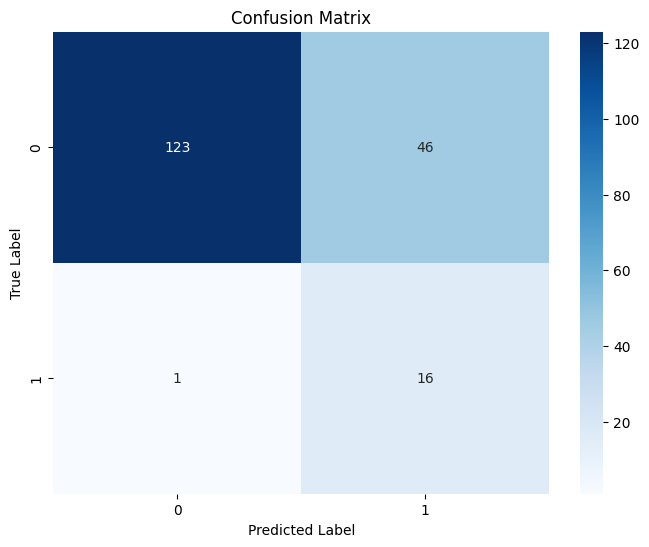

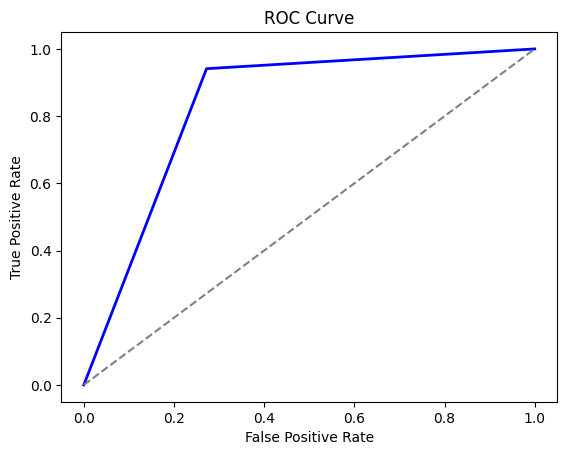

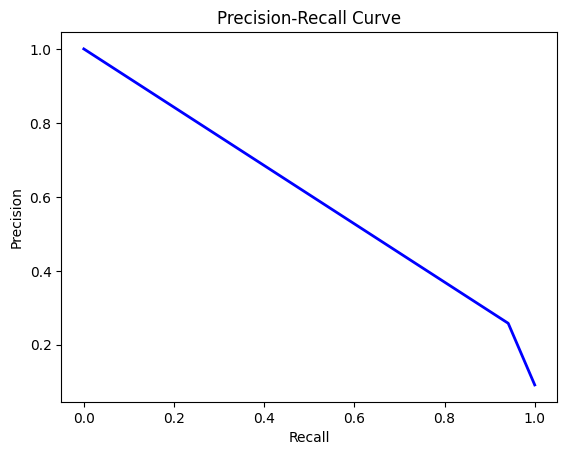

In [ ]:
# Calculate False Positives and False Negatives
false_positives = np.sum((predictions == 1) & (true_test_label == 0))
false_negatives = np.sum((predictions == 0) & (true_test_label == 1))

print("False Positives:", false_positives)
print("False Negatives:", false_negatives)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Visualize ROC Curve
fpr, tpr, thresholds = roc_curve(true_test_label, predictions)
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Visualize Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_test_label, predictions)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

**Receiver Operating Characteristic (ROC) Curve:**

The ROC curve illustrates the performance of a binary classifier system as its discrimination threshold is varied. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.
AUC (Area Under the Curve) is often used to summarize the ROC curve.

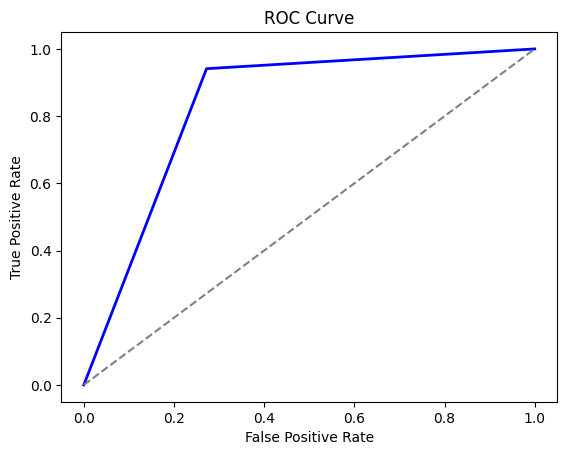

In [ ]:
# Visualize ROC Curve
fpr, tpr, thresholds = roc_curve(true_test_label, predictions)
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

**Precision-Recall Curve:**

The precision-recall curve plots Precision against Recall for different threshold values.
It is useful when the positive class is rare (as in your case with anomalies), or when you care more about false positives than false negatives.

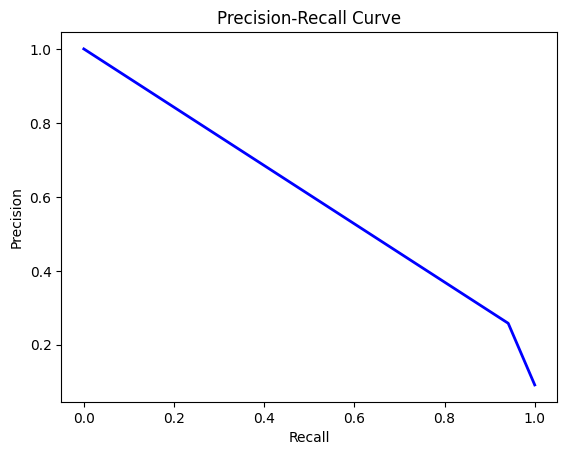

In [ ]:
# Visualize Precision-Recall Curve
precision, recall, _ = precision_recall_curve(true_test_label, predictions)
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


**Cross-Validation:**

Cross-validation assesses how well a model generalizes to new data.
It involves splitting the dataset into multiple folds, training the model on several combinations of folds, and evaluating its performance on the remaining fold(s).

In [ ]:
# Implement Cross-Validation
from sklearn.model_selection import cross_val_score

# Example of 5-fold cross-validation
cv_scores = cross_val_score(knn_model, test_embeddings, true_test_label, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)

Cross-Validation Scores: [0.97368421 0.97297297 0.94594595 0.97297297 0.94594595]


**Hyperparameter Tuning:**

Hyperparameter tuning involves searching for the best hyperparameters of the model to optimize its performance.
Grid Search and Random Search are common techniques for hyperparameter tuning

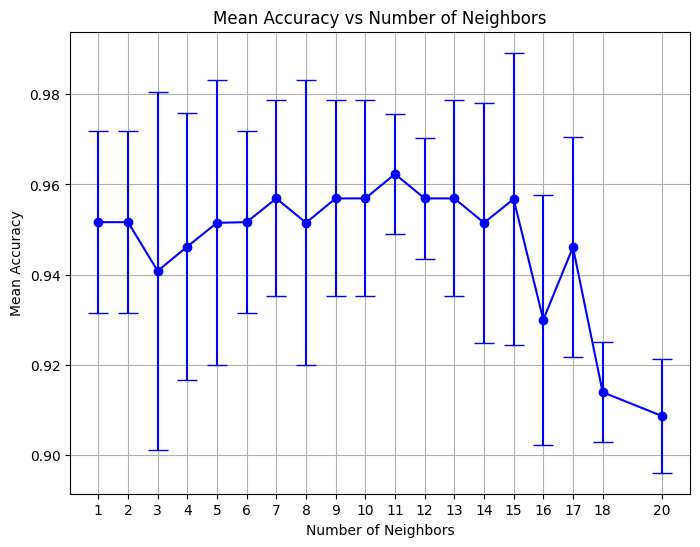

In [ ]:
# Hyperparameter Tuning Visualization (Grid Search Heatmap)
from sklearn.model_selection import GridSearchCV
import seaborn as sns

# Define parameter grid
param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10 ,11, 12, 13, 14, 15, 16, 17, 18, 20]}

grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(test_embeddings, true_test_label)

# Extract results of grid search
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']
param_range = param_grid['n_neighbors']

# Plot mean accuracy with standard deviation error bars
plt.figure(figsize=(8, 6))
plt.errorbar(param_range, mean_scores, yerr=std_scores, fmt='-o', color='b', capsize=7)
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Number of Neighbors')
plt.xticks(param_range)
plt.grid(True)
plt.show()


dimensions of test distance (186,)
True Positives (TP) for Test (KNN): 123
True Negatives (TN) for Test (KNN): 16
False Positives (FP) for Test (KNN): 1
False Negatives (FN) for Test (KNN): 46






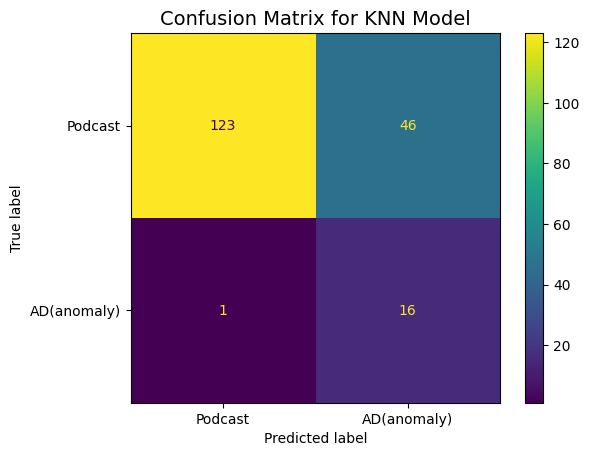





Accuracy for Test Set (KNN): 74.73%
Precision for Test Set (KNN): 25.81%
Recall for Test Set (KNN): 0.94%
F1 Score for KNN Model: 0.41%
F2 Score for Test Set (favored towards recall): 0.62%






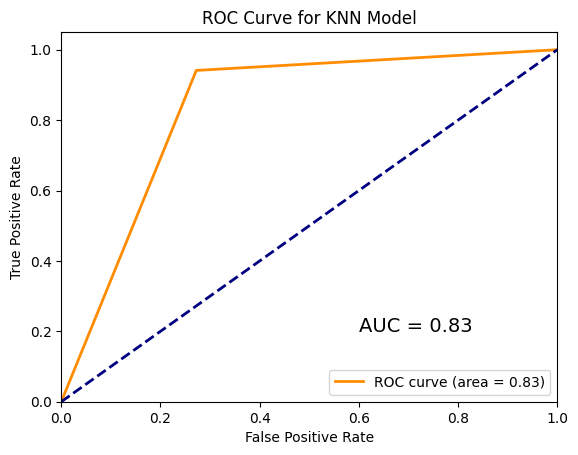





AUC Score for Test Set: 0.8344935607379046


In [14]:
# from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score
# from sklearn.metrics import ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, accuracy_score, fbeta_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict anomalies using the KNN model
anomaly_predictions_test_knn = predict_knn(knn_model, test_embeddings, anomaly_threshold, normal_threshold)

# Calculate confusion matrix for test set
test_conf_matrix_knn = confusion_matrix(true_test_label, anomaly_predictions_test_knn)

# Extract TP, TN, FP, FN from confusion matrix
TP_test_knn = test_conf_matrix_knn[0, 0]  # Correctly predicted anomalies
TN_test_knn = test_conf_matrix_knn[1, 1]  # Correctly predicted normal instances
FP_test_knn = test_conf_matrix_knn[1, 0]  # Incorrectly predicted normal instances as anomalies
FN_test_knn = test_conf_matrix_knn[0, 1]  # Incorrectly predicted anomalies as normal instances

print("True Positives (TP) for Test (KNN):", TP_test_knn)
print("True Negatives (TN) for Test (KNN):", TN_test_knn)
print("False Positives (FP) for Test (KNN):", FP_test_knn)
print("False Negatives (FN) for Test (KNN):", FN_test_knn)

# Display confusion matrix for test set (KNN)
print("\n\n\n")
cm_display_test_knn = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix_knn, display_labels=["Podcast", "AD(anomaly)"])
cm_display_test_knn.plot()
plt.title('Confusion Matrix for KNN Model',fontsize=14)
plt.show()
print("\n\n\n")

# Calculate accuracy for test set (KNN)
accuracy_test_knn = accuracy_score(true_test_label, anomaly_predictions_test_knn)
accuracy_percentage = "{:.2f}%".format(accuracy_test_knn * 100)
print("Accuracy for Test Set (KNN):", accuracy_percentage)

# Calculate precision for test set (KNN)
precision_test_knn = precision_score(true_test_label, anomaly_predictions_test_knn)
precision_percentage = "{:.2f}%".format(precision_test_knn * 100)
print("Precision for Test Set (KNN):", precision_percentage)

# Calculate recall for test set (KNN)
recall_test_knn = recall_score(true_test_label, anomaly_predictions_test_knn)
recall_percentage = "{:.2f}%".format(recall_test_knn)

print("Recall for Test Set (KNN):", recall_percentage)

# Calculate F1-score for test set (KNN)
f1_test_knn = f1_score(true_test_label, anomaly_predictions_test_knn)
f1_percentage = "{:.2f}%".format(f1_test_knn)
print("F1 Score for KNN Model:", f1_percentage)


# Calculate F-beta score for test set (favored towards recall)
fbeta_test = fbeta_score(true_test_label, anomaly_predictions_test_knn, beta=2)
fbeta_percentage = "{:.2f}%".format(fbeta_test)
print("F2 Score for Test Set (favored towards recall):", fbeta_percentage)

#add the value of F_beta score?

# Calculate AUC score for test set (KNN)
fpr_test_knn, tpr_test_knn, _ = roc_curve(true_test_label, anomaly_predictions_test_knn)
roc_auc_test_knn = auc(fpr_test_knn, tpr_test_knn)

# print("\n\n\n")

# # Plot ROC curve for test set (KNN)
# plt.figure()
# plt.plot(fpr_test_knn, tpr_test_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_knn)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic for Test Set (KNN)')
# plt.legend(loc="lower right")
# plt.show()
# print("\n\n\n")


# # Display AUC score for test set (KNN)
# print("AUC Score for Test Set (KNN):", roc_auc_test_knn)

# Plot ROC curve for test set
print("\n\n\n")

plt.figure()
plt.plot(fpr_test_knn, tpr_test_knn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.text(0.6, 0.2, 'AUC = %0.2f' % roc_auc_test_knn, fontsize=14)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNN Model')
plt.legend(loc="lower right")
plt.show()
print("\n\n\n")

# Display AUC score for test set
print("AUC Score for Test Set:", roc_auc_test_knn)

# ***from here not relevant code***

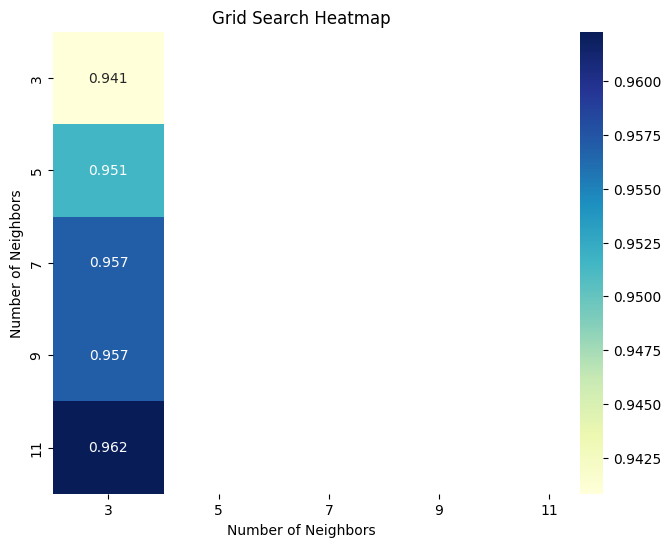

In [ ]:
# Hyperparameter Tuning (Example using Grid Search)
# Hyperparameter Tuning Visualization (Grid Search Heatmap)
import seaborn as sns

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform Grid Search
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(test_embeddings, true_test_label)

# Extract results of grid search
results = grid_search.cv_results_
mean_scores = results['mean_test_score'].reshape(len(param_grid['n_neighbors']), -1)

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(mean_scores, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=param_grid['n_neighbors'], yticklabels=param_grid['n_neighbors'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Number of Neighbors')
plt.title('Grid Search Heatmap')
plt.show()

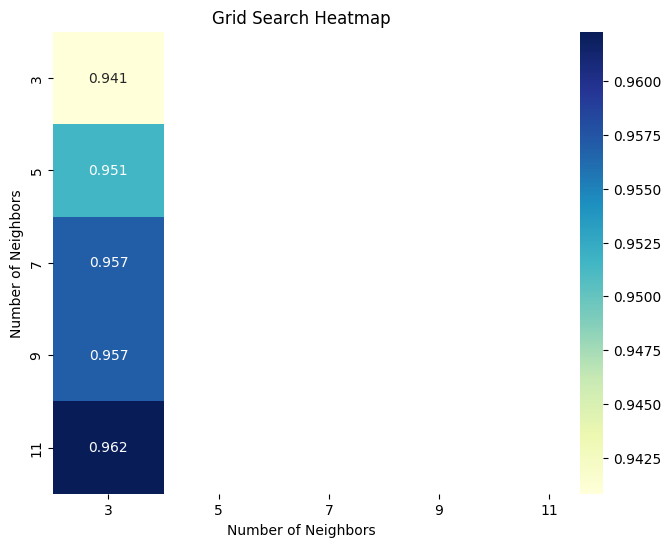

In [ ]:
# Hyperparameter Tuning Visualization (Grid Search Heatmap)
import seaborn as sns

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform Grid Search
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(test_embeddings, true_test_label)

# Extract results of grid search
results = grid_search.cv_results_
mean_scores = results['mean_test_score'].reshape(len(param_grid['n_neighbors']), -1)

# Create heatmap with proper tick labels
plt.figure(figsize=(8, 6))
sns.heatmap(mean_scores, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=param_grid['n_neighbors'], yticklabels=param_grid['n_neighbors'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Number of Neighbors')
plt.title('Grid Search Heatmap')
plt.show()

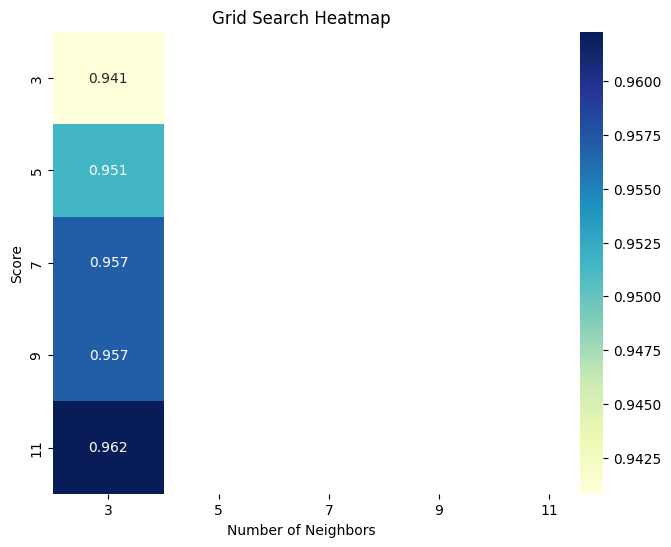

In [ ]:
# Hyperparameter Tuning Visualization (Grid Search Heatmap)
import seaborn as sns

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform Grid Search
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(test_embeddings, true_test_label)

# Extract results of grid search
results = grid_search.cv_results_
mean_scores = results['mean_test_score'].reshape(len(param_grid['n_neighbors']), -1)

# Create heatmap with proper tick labels
plt.figure(figsize=(8, 6))
sns.heatmap(mean_scores, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=param_grid['n_neighbors'], yticklabels=param_grid['n_neighbors'])
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('Grid Search Heatmap')
plt.show()


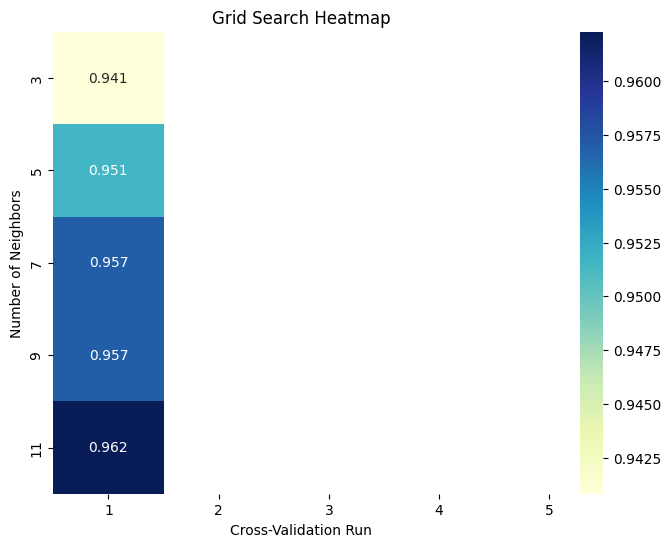

In [ ]:
# Hyperparameter Tuning Visualization (Grid Search Heatmap)
import seaborn as sns

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Perform Grid Search
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(test_embeddings, true_test_label)

# Extract results of grid search
results = grid_search.cv_results_
mean_scores = results['mean_test_score'].reshape(len(param_grid['n_neighbors']), -1)

# Create heatmap with proper tick labels
plt.figure(figsize=(8, 6))
sns.heatmap(mean_scores, annot=True, fmt=".3f", cmap="YlGnBu", xticklabels=range(1, 6), yticklabels=param_grid['n_neighbors'])
plt.xlabel('Cross-Validation Run')
plt.ylabel('Number of Neighbors')
plt.title('Grid Search Heatmap')
plt.show()